## Initial preparation

In [1]:
from matplotlib.pyplot import imshow
import numpy as np
import sys
import visdom as vis

sys.path.append('/garmentor/')

from models.smpl_official import easy_create_smpl_model
from vis.visualizers.keypoints import KeypointsVisualizer
from vis.visualizers.body import BodyVisualizer
from vis.visualizers.clothed import ClothedVisualizer
from vis.visualizers.clothed3d import ClothedVisualizer3D
from vis.logger import VisLogger
from data.generate.pregenerator import DataPreGenerator

## Random parameters

In [2]:
data_generator = DataPreGenerator()
pose, shape, style_vector, cam_t = data_generator.generate_random_params()

#pose[0] = 0.
#pose[1] = 0.
#pose[2] = 0.

#from tailornet_for_garmentor.utils.rotation import normalize_y_rotation

#print(pose)
#pose = normalize_y_rotation(pose)
#print(pose)

## Visualize keypoints

In [3]:
keypoints_visualizer_orthographic = KeypointsVisualizer(projection_type='orthographic')
keypoints_visualizer_perspective = KeypointsVisualizer(projection_type='perspective')

[KeypointVisualizer] Projection: orthographic
[KeypointVisualizer] Using None SMPL.
[KeypointVisualizer] Projection: perspective
[KeypointVisualizer] Using None SMPL.


Saved keypoints image: out/keypoints.png...


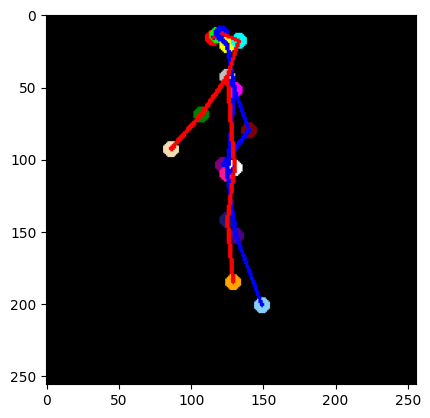

In [4]:
kpt_img_orthographic = keypoints_visualizer_orthographic.vis_from_params(
    pose=pose,
    shape=shape,
    cam_t=cam_t,
    gender='male'
)
imshow(kpt_img_orthographic)
keypoints_visualizer_orthographic.save_vis(kpt_img_orthographic, 'out/keypoints.png')

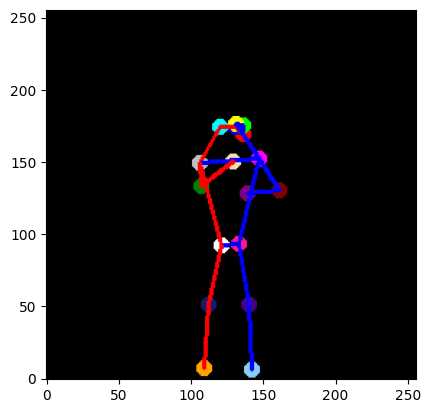

In [6]:
kpt_img_perspective = keypoints_visualizer_orthographic.vis_from_params(
    pose=pose,
    shape=shape,
    cam_t=cam_t,
    gender='male'
)
imshow(kpt_img_perspective)

## Visualize body


Renderer projection type: perspective
[BodyVisualizer] Using None SMPL.
Saved body image: out/body.png...


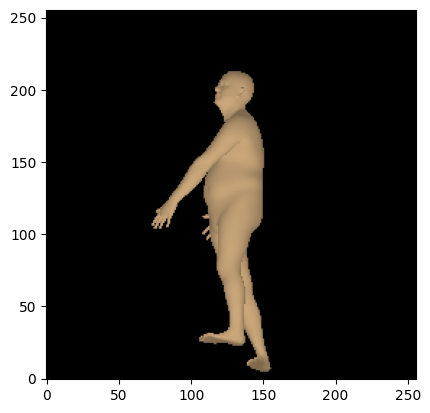

In [5]:
# NOTE: The image is not inversed, i.e., the coordinates are inverse, opposite to what the keypoints have, which is OK.
# NOTE: The orientations [0., 0., 0.] are inversed w.r.t. to the ones loaded from the pose dataset.
body_visualizer = BodyVisualizer(device='cpu')
body_img, body_mask = body_visualizer.vis_from_params(
    pose=pose,
    shape=shape,
    cam_t=cam_t,
    gender='male'
)
imshow(body_img / 255., origin='lower')
#imshow(body_img / 255.)
#cv2.imwrite('out/body.png', body_img)
body_visualizer.save_vis(body_img, 'out/body.png')

## Conclusions

### Orientations

**Body visualizer.** The body visualizer uses renderers. The renderers account for the inverse standard of the visualization packages such as matplotlib and cv2 and therefore return the body in a "proper" orientation for the visualization. However, the body is in fact inversed w.r.t. to the actual values inside of the resulting numpy array, i.e., the head has a smaller coordinate than the feet. This means that the values which would go into the model are incorrect, i.e., the model unnecessarily learns inversed models, instead of the non-inversed ones.

**Renderer**. In order for subject to face the camera, the camera needs to be put at look-at position of 180 degree-angle.

**Keypoints visualizer.** On the contrary, the keypoints visualizer does not use renderers. The keypoint projections are done "manually", which makes the projections done properly and the resulting values correct, i.e., non-inversed. This is good for the model, but not good for the visualization. In order to properly visualize the keypoints using the visualization packages, the keypoint coordinates should be inversed.

### White body images

White body images do not happen because of the errors in the rendering process. Instead, the white color comes from the fact that the values are clipped to 1. because the expected range for the visualization package is [0., 1.] and not [0, 255]. So, the images fed to the model should be correct, but they are not properly shown in Visdom.

## Clothed visualizer

In [6]:
clothed_visualizer = ClothedVisualizer(
    gender='male',
    upper_class='t-shirt',
    lower_class='pant',
    device='cpu'
)
clothed_img, clothed_mask, joints_3d = clothed_visualizer.vis_from_params(
    pose=pose,
    shape=shape,
    style_vector=style_vector,
    cam_t=cam_t
)

Initializing (male, t-shirt, pant) model...
USING LF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_lf/t-shirt_male
USING HF LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male
USING SS2G LOG DIR:  /data/tailornet/weights/t-shirt_male_weights/tn_orig_ss2g/t-shirt_male
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_000/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_023/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_002/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/006_016/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/007_018/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_009/lin.pth.tar
loading /data/tailornet/weights/t-shirt_male_weights/tn_orig_hf/t-shirt_male/008_007/lin.pth.tar
loading /

Saved clothed image: out/clothed_rgb.png...


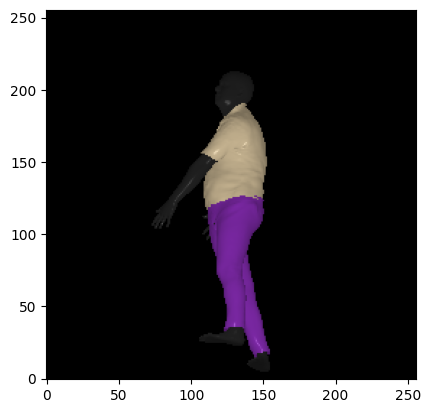

In [7]:
# NOTE: The RGB image here is not divided by 255, i.e., the values are [0., 1.].
imshow(clothed_img, origin='lower')
#cv2.imwrite('out/clothed_rgb.png', clothed_img * 255)
clothed_visualizer.save_vis(clothed_img, 'out/clothed_rgb.png')

Saved clothing segmentation masks: out/masks.npz...


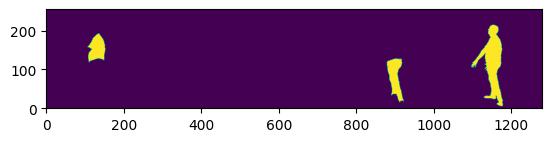

In [9]:
imshow(np.hstack(clothed_mask), origin='lower')
clothed_visualizer.save_masks(clothed_mask, 'out/masks.npz')

## Visualizer 3D

In [10]:
visualizer_3d = ClothedVisualizer3D(
    gender='male',
    upper_class='t-shirt',
    lower_class='pant'
)

AttributeError: 'TexturedGarmentsMeshManager' object has no attribute '_generate_body_texture_from_texture'

## Logger (torch)

In [ ]:
# First, create visdom process as `visdom -p {args.vport} > /dev/null 2>&1`

vport = 8889
visdom = vis.Visdom(port=vport)

In [ ]:
smpl_model = easy_create_smpl_model(
    gender='male',
    device='cpu'
)

In [ ]:
logger = VisLogger(
    device='cpu',
    visdom=visdom,
    smpl_model=smpl_model
)